In [9]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from wordcloud import WordCloud

# Understanding the dataset

In [10]:
data = pd.read_csv("data/train.csv")
data.head()

,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1


**In the 'label' column:**
- 1 is unreliable
- 2 is reliable

Now, let us check for any missing values and display basic statistics of the dataset

In [13]:
print(data.info())
print("\n")
print(data.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20800 entries, 0 to 20799
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      20800 non-null  int64 
 1   title   20242 non-null  object
 2   author  18843 non-null  object
 3   text    20761 non-null  object
 4   label   20800 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 812.6+ KB
None


                 id         label
count  20800.000000  20800.000000
mean   10399.500000      0.500625
std     6004.587135      0.500012
min        0.000000      0.000000
25%     5199.750000      0.000000
50%    10399.500000      1.000000
75%    15599.250000      1.000000
max    20799.000000      1.000000


The distribution of the 'label' column is shown below

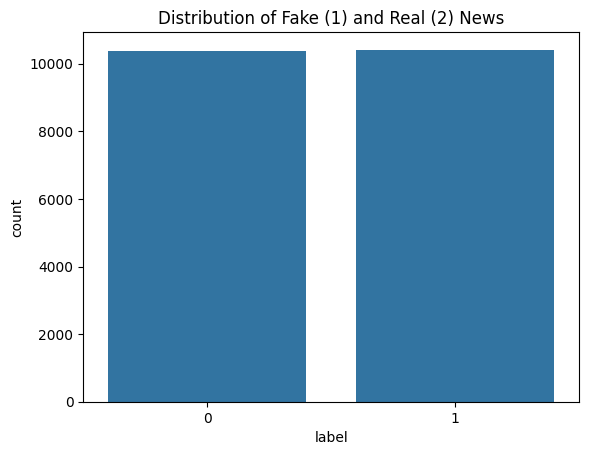

In [14]:
sns.countplot(x='label', data=data)

plt.title('Distribution of Fake (1) and Real (2) News')
plt.show()

The count plot above shows that fake and real news is in equal distribution within the dataset.

# Bag-of-words approach

Let us first start by tokenising and creating a bag-of-words representation

In [15]:
tfidf_vectorizer = TfidfVectorizer(stop_words='english')

X = tfidf_vectorizer.fit_transform(data['text'])

ValueError: np.nan is an invalid document, expected byte or unicode string.